In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
import numpy as np
import csv
from ultralytics import YOLO
from scipy.spatial.distance import euclidean
from collections import defaultdict
import os

model = YOLO("/content/bestJAT8x.pt")  # Load YOLOv8 model
video_path = "/content/InputVideo.mp4"
cap = cv2.VideoCapture(video_path)

PIXEL_TO_METER = 0.05
FPS = 30
FRAME_SKIP = 3  # Process every 3rd frame

frame_id = 0
vehicle_tracks = defaultdict(list)
output_data = []  # For PET/TTC results CSV
vlm_triplets = []  # For VLM dataset CSV

# Create output folders for frames & visualizations
os.makedirs("frames", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

def compute_speed(track):
    if len(track) < 2:
        return 0.0
    (f1, x1, y1), (f2, x2, y2) = track[-2], track[-1]
    dist_pixels = euclidean((x1, y1), (x2, y2))
    dist_meters = dist_pixels * PIXEL_TO_METER
    time_seconds = (f2 - f1) / FPS
    return dist_meters / time_seconds if time_seconds > 0 else 0.0

def compute_pet(track1, track2):
    min_dist = float("inf")
    pet = None
    for p1 in track1:
        for p2 in track2:
            d = euclidean(p1[1:], p2[1:])
            if d < min_dist:
                min_dist = d
                pet = abs(p1[0] - p2[0]) / FPS
    return pet, min_dist

def compute_ttc(pos1, pos2, speed_rel):
    if speed_rel <= 0:
        return float("inf")
    dist_pixels = euclidean(pos1, pos2)
    dist_meters = dist_pixels * PIXEL_TO_METER
    return dist_meters / speed_rel

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    if frame_id % FRAME_SKIP != 0:
        continue  # Skip frames

    detections = model.track(source=frame, persist=True, verbose=False)
    boxes = detections[0].boxes

    # Draw bounding boxes and track vehicles for this frame
    # Also keep dict of current detected vehicle info for visualization
    current_vehicles = {}

    if boxes is not None:
        for box in boxes:
            cls_id = int(box.cls)
            track_id = int(box.id)
            # Vehicle classes from COCO: bicycle(1), car(2), motorcycle(3), bus(5), train(7), truck(9)
            # Adjust if your model uses different class IDs
            if cls_id in [2, 3, 5, 7]:  # safer to limit to common vehicle classes
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                vehicle_tracks[track_id].append((frame_id, cx, cy))
                current_vehicles[track_id] = (cls_id, x1, y1, x2, y2)

    # PET & TTC analysis for this frame
    ids = list(current_vehicles.keys())
    frame_pairs_found = False

    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            id1, id2 = ids[i], ids[j]
            tr1, tr2 = vehicle_tracks[id1], vehicle_tracks[id2]
            if len(tr1) < 2 or len(tr2) < 2:
                continue

            pos1, pos2 = tr1[-1][1:], tr2[-1][1:]
            speed1 = compute_speed(tr1)
            speed2 = compute_speed(tr2)
            rel_speed = abs(speed1 - speed2)

            # Skip if too far apart to matter
            if euclidean(pos1, pos2) > 150:
                continue

            ttc = compute_ttc(pos1, pos2, rel_speed)
            pet, dist = compute_pet(tr1, tr2)

            output_data.append({
                "frame": frame_id,
                "vehicle_1_id": id1,
                "vehicle_2_id": id2,
                "pet_sec": round(pet, 2),
                "ttc_sec": round(ttc, 2),
                "min_distance_px": round(dist, 2),
            })

            # Add triplet for VLM training:
            # Save image filename + caption describing this vehicle pair interaction
            img_filename = f"frames/frame_{frame_id:05d}.jpg"
            caption = (
                f"Vehicles {id1} and {id2} have PET {pet:.2f} seconds, "
                f"TTC {ttc:.2f} seconds, minimum distance {dist:.2f} pixels."
            )
            vlm_triplets.append({
                "image": img_filename,
                "caption": caption,
                "vehicle_1_id": id1,
                "vehicle_2_id": id2,
                "pet_sec": round(pet, 2),
                "ttc_sec": round(ttc, 2),
                "min_distance_px": round(dist, 2),
            })

            frame_pairs_found = True

    # Save current frame image (for VLM triplets & visualization)
    frame_filename = f"frames/frame_{frame_id:05d}.jpg"
    cv2.imwrite(frame_filename, frame)

    # Draw visualization on frame copy
    vis_frame = frame.copy()
    for tid, (cls_id, x1, y1, x2, y2) in current_vehicles.items():
        # Draw box
        cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Put text: ID and class
        label = f"ID {tid} Cls {cls_id}"
        cv2.putText(vis_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 2)

    # Optionally, write PET/TTC info near vehicle pairs (show on top-left corner)
    # Collect all pet/ttc for this frame and write together
    pet_ttc_texts = []
    for pair in output_data[-len(vlm_triplets):]:
        if pair["frame"] == frame_id:
            pet_ttc_texts.append(
                f"IDs {pair['vehicle_1_id']} & {pair['vehicle_2_id']}: PET={pair['pet_sec']}s TTC={pair['ttc_sec']}s"
            )
    y0 = 20
    for i, text in enumerate(pet_ttc_texts):
        y = y0 + i * 20
        cv2.putText(vis_frame, text, (10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (0, 0, 255), 1)

    vis_filename = f"visualizations/frame_{frame_id:05d}.jpg"
    cv2.imwrite(vis_filename, vis_frame)

cap.release()

# Write PET & TTC CSV if data exists
if output_data:
    csv_filename = "pet_ttc_results.csv"
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=output_data[0].keys())
        writer.writeheader()
        writer.writerows(output_data)
    print(f"\n✅ PET and TTC results exported to '{csv_filename}'")
else:
    print("⚠️ No PET and TTC data found, CSV not created.")

# Write VLM triplets CSV if data exists
if vlm_triplets:
    vlm_csv = "vlm_triplets.csv"
    with open(vlm_csv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=vlm_triplets[0].keys())
        writer.writeheader()
        writer.writerows(vlm_triplets)
    print(f"✅ VLM triplets data exported to '{vlm_csv}'")
else:
    print("⚠️ No VLM triplet data found, CSV not created.")



✅ PET and TTC results exported to 'pet_ttc_results.csv'
✅ VLM triplets data exported to 'vlm_triplets.csv'


In [ ]:
import pandas as pd
import json
from collections import defaultdict

# Load and clean column names
df = pd.read_csv("/content/vlm_triplets.csv")
df.columns = df.columns.str.strip().str.replace(r"[^\w]+", "", regex=True)

# Build grouped JSON structure
image_data = defaultdict(list)

for _, row in df.iterrows():
    img_path = row["image"]
    v1 = int(row["vehicle_1_id"])
    v2 = int(row["vehicle_2_id"])
    pet = round(row["pet_sec"], 2)
    ttc = round(row["ttc_sec"], 2)
    dist = round(row["min_distance_px"], 2)

    question = f"What are the PET, TTC, and minimum distance between Vehicle {v1} and Vehicle {v2}?"
    answer = f"PET: {pet} sec, TTC: {ttc} sec, Min distance: {dist} px"

    image_data[img_path].append(
        {"from": "human", "value": question}
    )
    image_data[img_path].append(
        {"from": "gpt", "value": answer}
    )

# Prepare final JSON
json_data = []
for image, conversations in image_data.items():
    json_data.append({
        "image": image,
        "conversations": conversations
    })

# Save to file
with open("vlm_training_data_grouped.json", "w") as f:
    json.dump(json_data, f, indent=2)


In [ ]:
import json
import uuid

with open('/content/vlm_training_data_grouped.json') as f:
    data = json.load(f)

for item in data:
    item['id'] = str(uuid.uuid4())

with open('vlm_dataset.json', 'w') as f:
    json.dump(data, f, indent=2)


In [ ]:
pip install matplotlib seaborn pandas

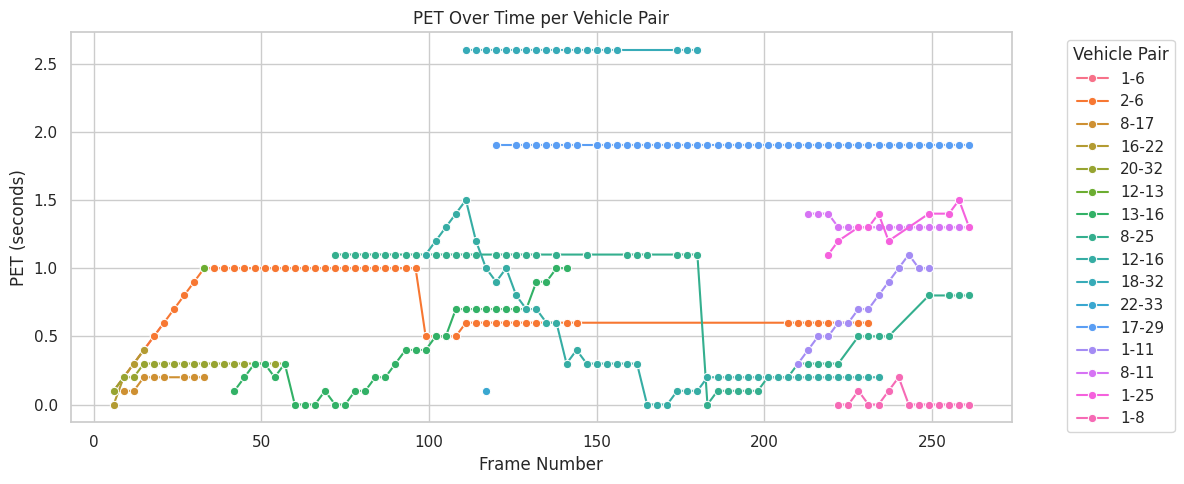

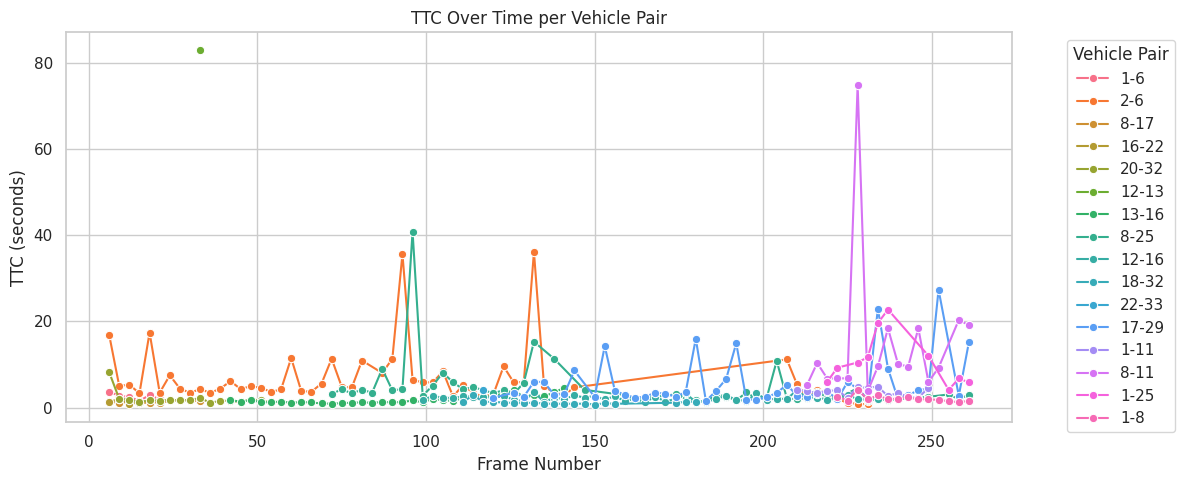

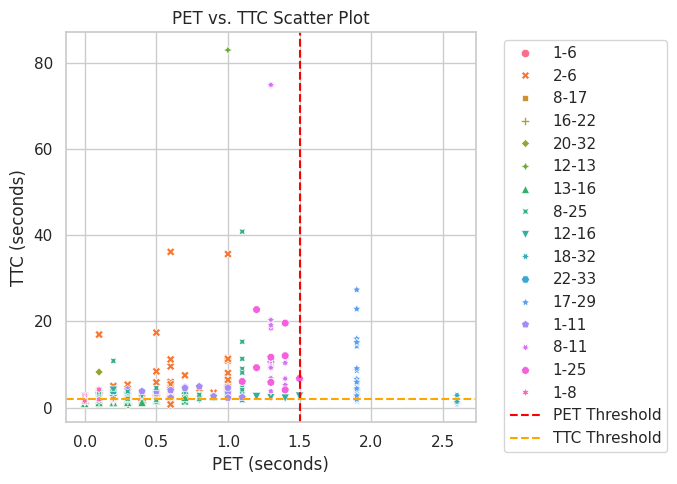

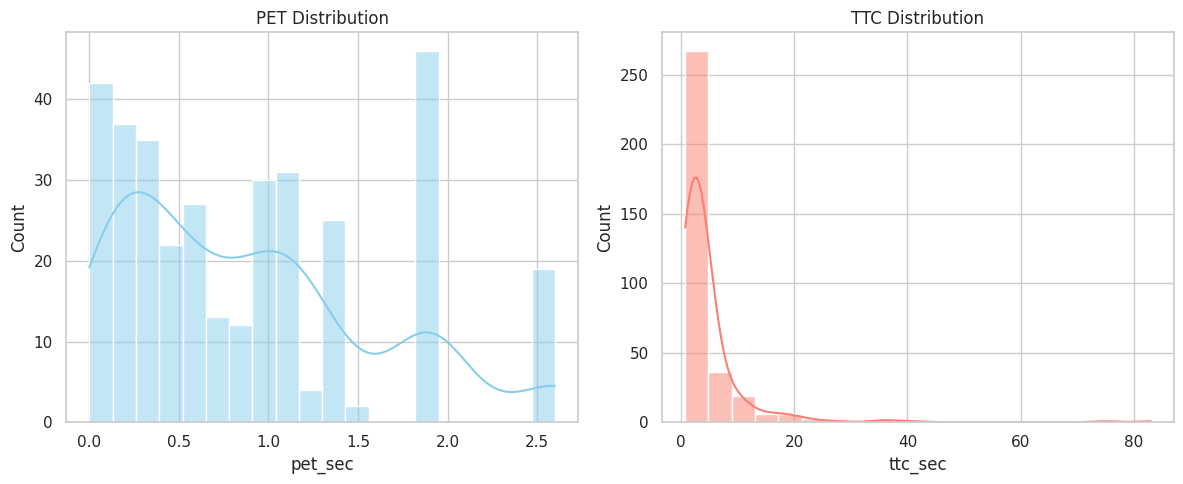

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv("/content/pet_ttc_results.csv")

# Combine vehicle pair into a single string for plotting
df["vehicle_pair"] = df["vehicle_1_id"].astype(str) + "-" + df["vehicle_2_id"].astype(str)

sns.set(style="whitegrid")

# --- 1. PET over Time ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="frame", y="pet_sec", hue="vehicle_pair", marker="o")
plt.title("PET Over Time per Vehicle Pair")
plt.ylabel("PET (seconds)")
plt.xlabel("Frame Number")
plt.legend(title="Vehicle Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 2. TTC over Time ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="frame", y="ttc_sec", hue="vehicle_pair", marker="o")
plt.title("TTC Over Time per Vehicle Pair")
plt.ylabel("TTC (seconds)")
plt.xlabel("Frame Number")
plt.legend(title="Vehicle Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 3. Scatter Plot PET vs. TTC ---
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="pet_sec", y="ttc_sec", hue="vehicle_pair", style="vehicle_pair")
plt.axvline(x=1.5, color='red', linestyle='--', label='PET Threshold')
plt.axhline(y=2.0, color='orange', linestyle='--', label='TTC Threshold')
plt.title("PET vs. TTC Scatter Plot")
plt.xlabel("PET (seconds)")
plt.ylabel("TTC (seconds)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 4. Distribution Plots ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["pet_sec"], bins=20, kde=True, color="skyblue")
plt.title("PET Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df["ttc_sec"], bins=20, kde=True, color="salmon")
plt.title("TTC Distribution")

plt.tight_layout()
plt.show()


In [ ]:
!pip install transformers torchvision


In [ ]:
!pip install torch torchvision timm transformers


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
import timm
import json
import os

class VLMQADataset(Dataset):
    def __init__(self, json_path):
        self.data = []
        with open(json_path, 'r') as f:
            raw_data = json.load(f)
            for item in raw_data:
                image_path = os.path.join("/content", item['image'])  # ensures /content/frames/...
                for i in range(0, len(item["conversations"]), 2):
                    if i + 1 < len(item["conversations"]):
                        q = item["conversations"][i]["value"]
                        a = item["conversations"][i + 1]["value"]
                        self.data.append({
                            "image_path": image_path,
                            "question": q,
                            "answer": a
                        })

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['image_path']).convert("RGB")
        image = self.transform(image)
        return image, entry['question'], entry['answer']


class VLMQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vision_encoder.head = nn.Identity()

        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.decoder = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Linear(512, self.tokenizer.vocab_size)
        )

    def forward(self, image, question):
        vision_feats = self.vision_encoder(image)

        encoded = self.tokenizer(question, return_tensors='pt', padding=True, truncation=True)
        encoded = {k: v.to(image.device) for k, v in encoded.items()}
        text_feats = self.text_encoder(**encoded).pooler_output

        fused_feats = torch.cat((vision_feats, text_feats), dim=1)
        logits = self.decoder(fused_feats)
        return logits


def train_vlm(json_path, epochs=3, batch_size=4, lr=1e-4):
    dataset = VLMQADataset(json_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = VLMQAModel()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = model.tokenizer

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, questions, answers in dataloader:
            images = images.to(device)

            labels = tokenizer(answers, return_tensors='pt', padding=True, truncation=True)
            input_ids = labels['input_ids'].to(device)
            target_ids = input_ids[:, 0]  # use CLS token prediction as proxy

            logits = model(images, questions)
            loss = criterion(logits, target_ids)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

train_vlm('/content/vlm_dataset.json')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/3 - Loss: 0.3625
Epoch 2/3 - Loss: 0.0000
Epoch 3/3 - Loss: 0.0000


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
import timm
import json
import os

MAX_ANSWER_LEN = 32  # max length for answer sequences

class VLMQADataset(Dataset):
    def __init__(self, json_path):
        self.data = []
        with open(json_path, 'r') as f:
            raw_data = json.load(f)
            for item in raw_data:
                image_path = os.path.join("/content", item['image'])  # ensures /content/frames/...
                for i in range(0, len(item["conversations"]), 2):
                    if i + 1 < len(item["conversations"]):
                        q = item["conversations"][i]["value"]
                        a = item["conversations"][i + 1]["value"]
                        self.data.append({
                            "image_path": image_path,
                            "question": q,
                            "answer": a
                        })

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['image_path']).convert("RGB")
        image = self.transform(image)
        return image, entry['question'], entry['answer']

def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(questions), list(answers)

class VLMQAModel(nn.Module):
    def __init__(self, max_answer_len=MAX_ANSWER_LEN):
        super().__init__()
        self.max_answer_len = max_answer_len

        self.vision_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vision_encoder.head = nn.Identity()

        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Decoder: project fused features to sequence of vocab logits
        # We'll just repeat fused features for each token and predict token logits
        # Shape: batch x max_answer_len x vocab_size
        self.decoder = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Linear(512, self.tokenizer.vocab_size)
        )

    def forward(self, images, questions):
        device = images.device

        vision_feats = self.vision_encoder(images)  # (B, 768)

        encoded = self.tokenizer(questions, return_tensors='pt', padding=True, truncation=True)
        encoded = {k: v.to(device) for k, v in encoded.items()}
        text_feats = self.text_encoder(**encoded).pooler_output  # (B, 768)

        fused_feats = torch.cat((vision_feats, text_feats), dim=1)  # (B, 1536)

        # Repeat fused features max_answer_len times for sequence prediction
        fused_feats = fused_feats.unsqueeze(1).repeat(1, self.max_answer_len, 1)  # (B, max_answer_len, 1536)

        # Predict token logits for each position
        logits = self.decoder(fused_feats)  # (B, max_answer_len, vocab_size)
        return logits

def train_vlm(json_path, epochs=3, batch_size=4, lr=1e-4):
    dataset = VLMQADataset(json_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    model = VLMQAModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer = model.tokenizer

    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, questions, answers in dataloader:
            images = images.to(device)

            # Tokenize answers with padding and truncation
            labels = tokenizer(answers, return_tensors='pt', padding='max_length', truncation=True,
                               max_length=model.max_answer_len)
            input_ids = labels['input_ids'].to(device)  # (B, max_answer_len)

            logits = model(images, questions)  # (B, max_answer_len, vocab_size)

            # reshape logits and labels to (B*max_answer_len, vocab_size) and (B*max_answer_len)
            loss = criterion(logits.view(-1, logits.size(-1)), input_ids.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Run training
train_vlm('/content/vlm_dataset.json')


Epoch 1/3 - Loss: 4.4688
Epoch 2/3 - Loss: 3.3968
Epoch 3/3 - Loss: 3.3659


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
import timm
import json
import os

MAX_ANSWER_LEN = 32  # max answer length

class VLMQADataset(Dataset):
    def __init__(self, json_path, tokenizer):
        self.data = []
        self.tokenizer = tokenizer
        with open(json_path, 'r') as f:
            raw_data = json.load(f)
            for item in raw_data:
                image_path = os.path.join("/content", item['image'])
                for i in range(0, len(item["conversations"]), 2):
                    if i + 1 < len(item["conversations"]):
                        q = item["conversations"][i]["value"]
                        a = item["conversations"][i + 1]["value"]
                        self.data.append({
                            "image_path": image_path,
                            "question": q,
                            "answer": a
                        })

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['image_path']).convert("RGB")
        image = self.transform(image)

        question_encoding = self.tokenizer(entry['question'], padding='max_length', truncation=True,
                                           max_length=64, return_tensors='pt')
        answer_encoding = self.tokenizer(entry['answer'], padding='max_length', truncation=True,
                                         max_length=MAX_ANSWER_LEN, return_tensors='pt')

        # Squeeze to remove batch dim from tokenizer outputs
        question_input_ids = question_encoding['input_ids'].squeeze(0)
        question_attention_mask = question_encoding['attention_mask'].squeeze(0)
        answer_input_ids = answer_encoding['input_ids'].squeeze(0)

        return image, question_input_ids, question_attention_mask, answer_input_ids

def collate_fn(batch):
    images, q_ids, q_masks, a_ids = zip(*batch)
    images = torch.stack(images)
    q_ids = torch.stack(q_ids)
    q_masks = torch.stack(q_masks)
    a_ids = torch.stack(a_ids)
    return images, q_ids, q_masks, a_ids

class VLMQAModel(nn.Module):
    def __init__(self, tokenizer, max_answer_len=MAX_ANSWER_LEN, d_model=768, nhead=8, num_decoder_layers=6):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_answer_len = max_answer_len
        self.d_model = d_model

        # Vision encoder (ViT)
        self.vision_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vision_encoder.head = nn.Identity()  # output: (B, 768)

        # Text encoder (BERT)
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')

        # Linear projection to transformer d_model size (768)
        self.vision_proj = nn.Linear(768, d_model)
        self.text_proj = nn.Linear(768, d_model)

        # Transformer decoder to generate answer tokens
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Token embedding for decoder input tokens (answers)
        self.token_embedding = nn.Embedding(tokenizer.vocab_size, d_model)

        # Positional encoding for decoder inputs
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_answer_len, d_model), requires_grad=False)

        # Final linear layer to vocab logits
        self.output_linear = nn.Linear(d_model, tokenizer.vocab_size)

    def _generate_positional_encoding(self, max_len, d_model):
        # Standard sinusoidal positional encoding
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(1)  # (max_len, 1, d_model)

    def forward(self, images, question_ids, question_mask, answer_ids=None):
        """
        images: (B, 3, 224, 224)
        question_ids: (B, Q_len)
        question_mask: (B, Q_len)
        answer_ids: (B, A_len) - token ids for answers (for teacher forcing)
        """
        device = images.device
        batch_size = images.size(0)

        # Encode vision
        vision_feats = self.vision_encoder(images)  # (B, 768)
        vision_feats = self.vision_proj(vision_feats).unsqueeze(1)  # (B, 1, d_model)

        # Encode question text
        text_outputs = self.text_encoder(input_ids=question_ids, attention_mask=question_mask)
        text_feats = text_outputs.pooler_output  # (B, 768)
        text_feats = self.text_proj(text_feats).unsqueeze(1)  # (B, 1, d_model)

        # Combine vision + text encoder outputs as memory for decoder
        memory = torch.cat([vision_feats, text_feats], dim=1)  # (B, 2, d_model)
        memory = memory.transpose(0,1)  # Transformer expects (seq_len, batch, d_model)

        if answer_ids is not None:
            # Training mode - teacher forcing

            # Embed decoder inputs (answer tokens shifted right)
            # decoder input = answer_ids[:, :-1]
            decoder_input_ids = answer_ids[:, :-1]  # remove last token for input
            tgt = self.token_embedding(decoder_input_ids)  # (B, A_len-1, d_model)

            # Add positional encoding
            tgt = tgt + self.positional_encoding[:tgt.size(1)].squeeze(1).to(device)

            tgt = tgt.transpose(0,1)  # (A_len-1, B, d_model)

            # Generate target mask (causal mask to prevent attending to future tokens)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(device)

            # Decode
            output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)  # (A_len-1, B, d_model)

            output = output.transpose(0,1)  # (B, A_len-1, d_model)

            # Project to vocab logits
            logits = self.output_linear(output)  # (B, A_len-1, vocab_size)

            return logits
        else:
            # Inference mode (greedy decoding)
            generated = []
            input_ids = torch.full((batch_size, 1), self.tokenizer.cls_token_id, dtype=torch.long, device=device)  # start tokens
            for _ in range(self.max_answer_len):
                tgt = self.token_embedding(input_ids) + self.positional_encoding[:input_ids.size(1)].squeeze(1).to(device)
                tgt = tgt.transpose(0,1)
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(device)

                out = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)  # (seq_len, B, d_model)
                out = out.transpose(0,1)  # (B, seq_len, d_model)
                logits = self.output_linear(out[:, -1, :])  # (B, vocab_size)
                next_token = logits.argmax(dim=-1).unsqueeze(1)  # (B, 1)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                generated.append(next_token)

                # Stop if all batches produced EOS token
                if (next_token == self.tokenizer.sep_token_id).all():
                    break

            generated_ids = torch.cat(generated, dim=1)  # (B, seq_len)
            return generated_ids

def train_vlm(json_path, epochs=15, batch_size=8, lr=1e-4):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    dataset = VLMQADataset(json_path, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    model = VLMQAModel(tokenizer)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, question_ids, question_mask, answer_ids in dataloader:
            images = images.to(device)
            question_ids = question_ids.to(device)
            question_mask = question_mask.to(device)
            answer_ids = answer_ids.to(device)

            logits = model(images, question_ids, question_mask, answer_ids)  # (B, A_len-1, vocab_size)

            # Targets = answer_ids[:,1:] (shifted left)
            target = answer_ids[:, 1:]

            loss = criterion(logits.view(-1, logits.size(-1))